### Descrição do Problema
Modelo para um laboratório de análises clínicas que realiza testes de colesterol. O objetivo é avaliar se características dos pacientes, como idade, nível de atividade física e peso, podem influenciar nos resultados do exame de colesterol total.

## Importando Bibliotecas

In [173]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy.stats import zscore

from scipy.stats import shapiro, kstest, anderson
from statsmodels.stats.diagnostic import lilliefors, het_goldfeldquandt



## Carregar Dados

In [211]:
df_colesterol = pd.read_csv('./dataset/colesterol.csv')

In [212]:
df_colesterol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  1000 non-null   int64  
 1   Grupo Sanguíneo     996 non-null    object 
 2   Fumante             997 non-null    object 
 3   Nível de Atividade  996 non-null    object 
 4   Idade               997 non-null    float64
 5   Peso                997 non-null    float64
 6   Altura              997 non-null    float64
 7   Colesterol          1000 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 62.6+ KB


## Preparação do DataFrame


In [213]:
# Remover colunas que não serão utilizadas
df_colesterol.drop(columns=['Id'], axis=1, inplace=True)

In [214]:
# Renomear colunas para que fiquem com letras minúsculas e sem espaços
df_colesterol.columns = [
    'grupo_sanguineo',
    'fumante',
    'nivel_atividade_fisica',
    'idade',
    'peso',
    'altura',
    'nivel_colesterol'
  ]



In [215]:
# Copiar DF para DF EDA
df_colesterol_eda = df_colesterol.copy()

In [216]:
# Copiar DF para DF Bucketing
df_colesterol_bucketing = df_colesterol.copy()

## EDA

### Lidando com valores ausentes

In [217]:
# Detectar valores ausentes
df_colesterol_eda.isna().sum()

grupo_sanguineo           4
fumante                   3
nivel_atividade_fisica    4
idade                     3
peso                      3
altura                    3
nivel_colesterol          0
dtype: int64

In [218]:
# Medidas estatísticas
df_colesterol_eda.describe()

,idade,peso,altura,nivel_colesterol
count,997.000000,997.000000,997.000000,1000.000000
mean,49.206620,76.496690,174.889669,199.453260
std,17.476704,21.439132,8.844703,50.625152
min,20.000000,15.400000,160.000000,36.260000
25%,34.000000,61.700000,167.000000,166.345000
50%,49.000000,75.500000,175.000000,199.455000
75%,65.000000,90.200000,183.000000,233.785000
max,79.000000,158.100000,190.000000,372.670000


In [219]:
# Coletar medidas das variaveis categoricas
moda_grupo_sang = df_colesterol_eda.grupo_sanguineo.mode()
moda_fumante = df_colesterol_eda.fumante.mode()
moda_nivel_atividade = df_colesterol_eda.nivel_atividade_fisica.mode()

In [220]:
# Coletar medidas das variaveis numericas
mediana_idade = df_colesterol_eda.idade.median()
mediana_peso = df_colesterol_eda.peso.median()
mediana_altura = df_colesterol_eda.altura.median()

In [221]:
# Inputar valores ausentes
df_colesterol_eda.fillna(value={'grupo_sanguineo': moda_grupo_sang[0],
                         'fumante': moda_fumante[0],
                         'nivel_atividade_fisica': moda_nivel_atividade[0],
                         'idade': mediana_idade, 
                         'peso': mediana_peso, 
                         'altura': mediana_altura}, inplace=True)

### Convertendo varíaveis númericas

In [222]:
# Converter idade e altura para inteiro
df_colesterol_eda.idade = df_colesterol_eda.idade.astype(int)
df_colesterol_eda.altura = df_colesterol_eda.altura.astype(int)

In [223]:
df_colesterol_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grupo_sanguineo         1000 non-null   object 
 1   fumante                 1000 non-null   object 
 2   nivel_atividade_fisica  1000 non-null   object 
 3   idade                   1000 non-null   int32  
 4   peso                    1000 non-null   float64
 5   altura                  1000 non-null   int32  
 6   nivel_colesterol        1000 non-null   float64
dtypes: float64(2), int32(2), object(3)
memory usage: 47.0+ KB


### Tratamento de Outliers

<Axes: xlabel='idade'>

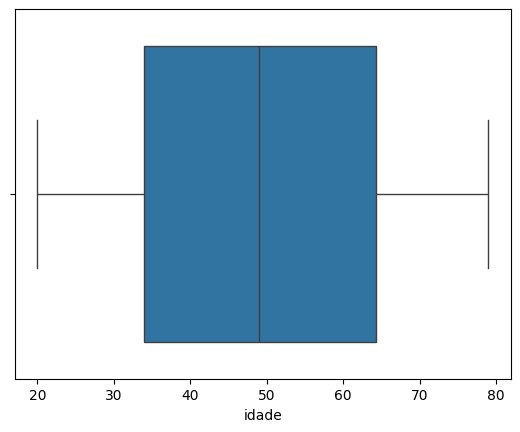

In [262]:
sns.boxplot(data=df_colesterol_eda, x='idade')

<Axes: xlabel='peso'>

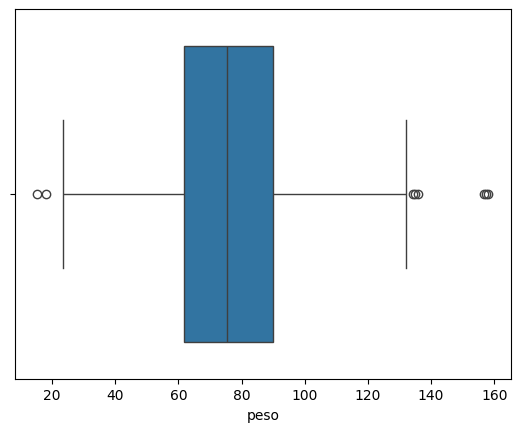

In [261]:
sns.boxplot(data=df_colesterol_eda, x='peso')

In [95]:
# Filtrar o público a ser removido
df_colesterol_eda[df_colesterol_eda['peso'] < 40].peso.count()

37

In [96]:
# Remover público filtrado do dataframe
df_colesterol_eda.drop(df_colesterol_eda[df_colesterol_eda['peso'] < 40].index, axis=0, inplace=True)

<Axes: xlabel='altura'>

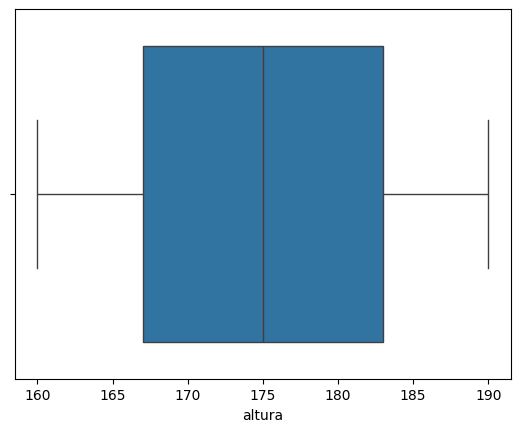

In [263]:
sns.boxplot(data=df_colesterol_eda, x='altura')

<Axes: xlabel='nivel_colesterol'>

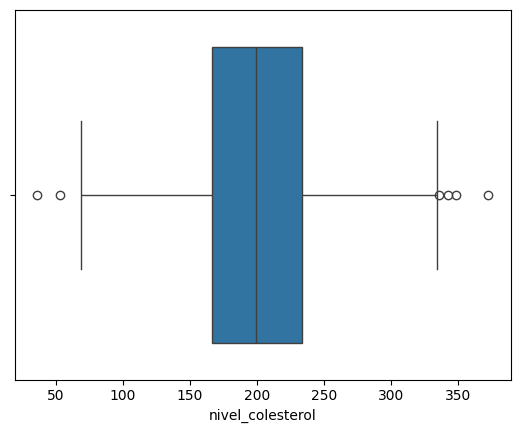

In [264]:
sns.boxplot(data=df_colesterol_eda,x='nivel_colesterol')

Observou-se a inexistência de outliers na variável altura, no entanto, foram identificados valores extremos no nível de colesterol, optando-se por sua inclusão no estudo. Posteriormente, procedeu-se à filtragem dos registros com peso inferior a 40 quilos, considerando a possibilidade de inserção incorreta de dados. Esses registros foram excluídos do DataFrame, resultando na redução do tamanho da amostra para a análise.

Ao realizar uma nova avaliação por meio de boxplots, foi novamente verificada a ausência de outliers na variável idade, porém identificaram-se outliers no peso. Decidiu-se, então, remover os registros associados a pesos muito baixos, devido à falta de congruência com o contexto do estudo. Essas ações visam garantir a integridade e relevância dos dados utilizados na análise, contribuindo para a consistência e confiabilidade dos resultados obtidos.

### Análises Gráficas

#### Variáveis Categóricas x Target

<Axes: xlabel='grupo_sanguineo', ylabel='nivel_colesterol'>

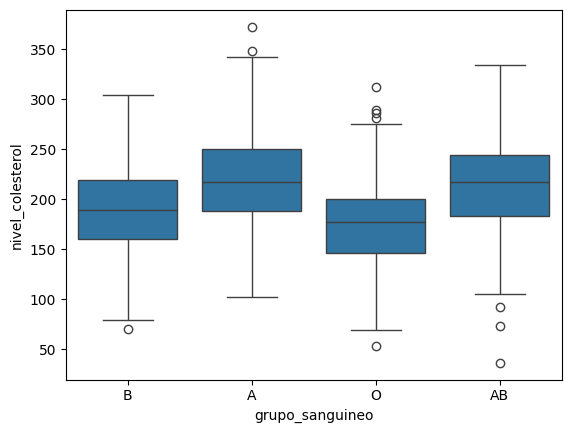

In [271]:

sns.boxplot(data=df_colesterol_eda, x='grupo_sanguineo', y='nivel_colesterol')


<Axes: xlabel='fumante', ylabel='nivel_colesterol'>

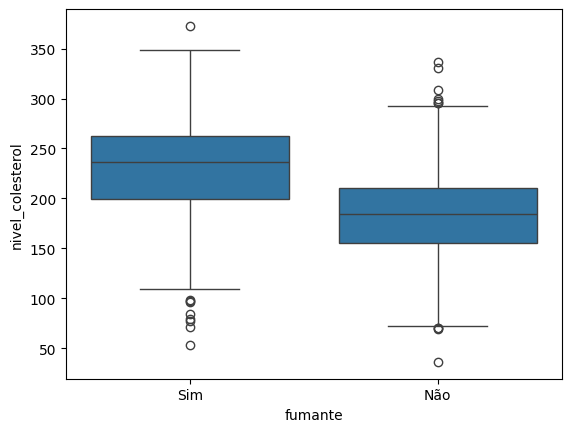

In [273]:

sns.boxplot(data=df_colesterol_eda, x='fumante', y='nivel_colesterol')

<Axes: xlabel='nivel_atividade_fisica', ylabel='nivel_colesterol'>

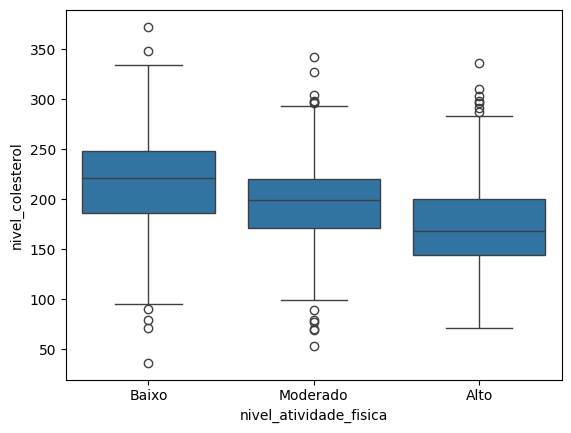

In [274]:
sns.boxplot(data=df_colesterol_eda, x='nivel_atividade_fisica', y='nivel_colesterol')

Foi observado que o grupo sanguíneo pode influenciar o nível de colesterol, sendo que os tipos O e B demonstram níveis inferiores em comparação aos tipos A e AB. Adicionalmente, identificamos uma tendência de elevação nos níveis de colesterol entre fumantes, ao passo que indivíduos com um alto nível de atividade física tendem a apresentar níveis mais baixos. Essas observações destacam a possível relação entre esses fatores específicos e os níveis de colesterol, contribuindo para uma compreensão mais abrangente dos padrões observados no estudo.

####  Variáveis Numéricas x Target

<Axes: xlabel='idade', ylabel='nivel_colesterol'>

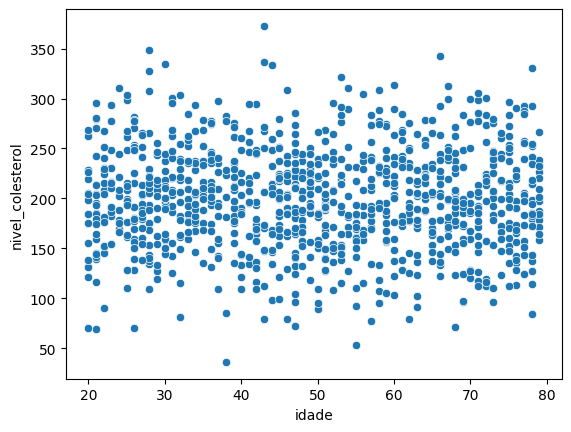

In [276]:
sns.scatterplot(data=df_colesterol_eda, x='idade', y='nivel_colesterol')

<Axes: xlabel='peso', ylabel='nivel_colesterol'>

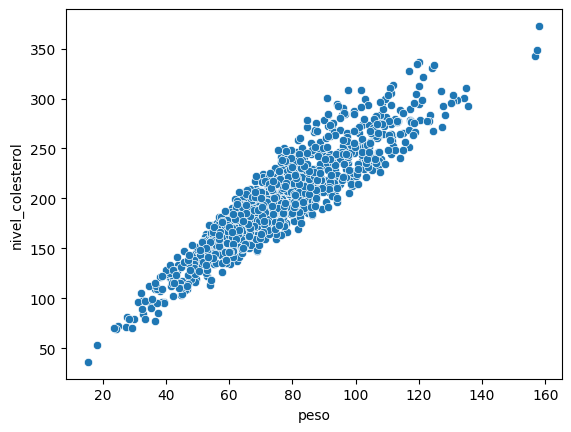

In [277]:
sns.scatterplot(data=df_colesterol_eda, x='peso', y='nivel_colesterol')

<Axes: xlabel='altura', ylabel='nivel_colesterol'>

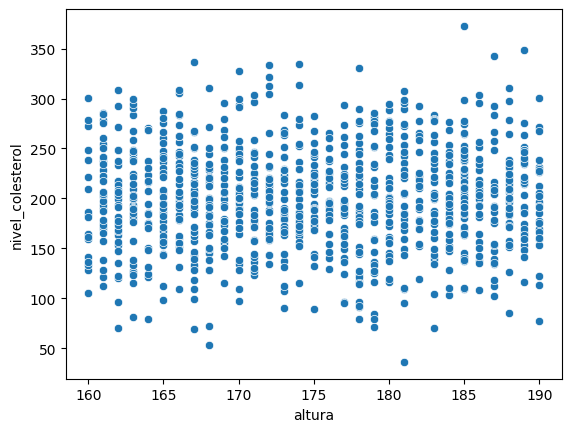

In [278]:
sns.scatterplot(data=df_colesterol_eda, x='altura', y='nivel_colesterol')


Observou-se, de maneira geral, uma tendência que sugere uma relação positiva entre o peso e o nível de colesterol. No entanto, também foram identificados outliers, indicando valores de colesterol consideravelmente elevados para determinados pesos. A detecção dessas discrepâncias é crucial, pois a presença de níveis de colesterol baixos em indivíduos com pesos elevados seria considerada atípica. Em seguida, realizou-se uma análise da relação entre altura e nível de colesterol, não revelando um padrão claro na associação entre essas variáveis. Essas observações contribuem para uma compreensão mais ampla das interações entre peso, altura e nível de colesterol no contexto do estudo.


#### Histogramas

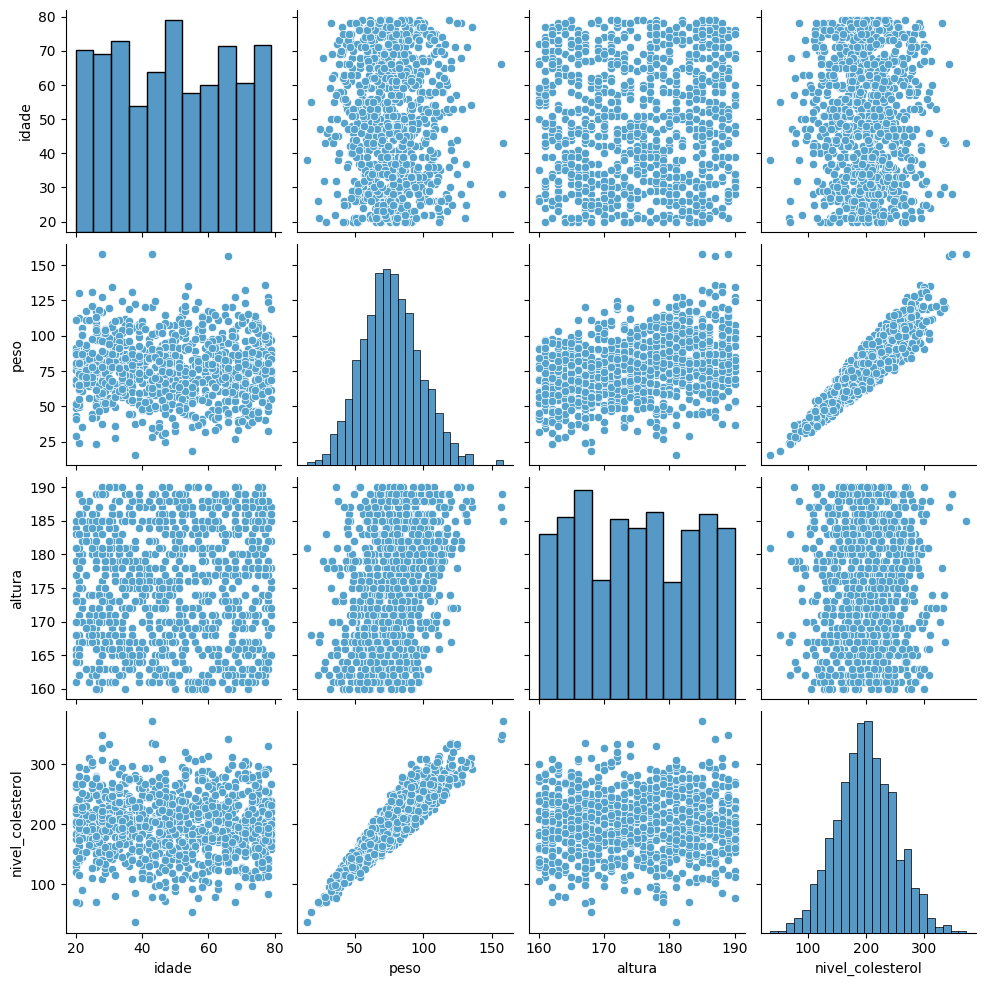

In [280]:
palette = sns.color_palette("icefire")
sns.pairplot(df_colesterol_eda, plot_kws={'color': palette[0]})

Não foram identificadas outras correlações significativas entre as variáveis independentes, o que é positivo para evitar multicolinearidade em nosso modelo

### Análise de Correlações

In [281]:
# Converter variáveis categoricas nominais em númericas (One Hot Encoder do Pandas)
df_colesterol_eda = pd.get_dummies(df_colesterol_eda, columns=['grupo_sanguineo','fumante'], dtype='int64')

In [282]:
df_colesterol_eda.head(10)

,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,grupo_sanguineo_A,grupo_sanguineo_AB,grupo_sanguineo_B,grupo_sanguineo_O,fumante_Não,fumante_Sim
0,Baixo,33,85.1,186,199.63,0,0,1,0,0,1
1,Moderado,68,105.0,184,236.98,1,0,0,0,1,0
2,Alto,25,64.8,180,161.79,0,0,0,1,1,0
3,Alto,43,120.2,167,336.24,1,0,0,0,1,0
4,Baixo,79,88.5,175,226.23,0,1,0,0,1,0
5,Baixo,68,66.8,170,185.31,0,0,1,0,1,0
6,Baixo,60,117.3,181,289.33,1,0,0,0,0,1
7,Moderado,35,86.9,174,216.48,0,0,0,1,0,1
8,Baixo,62,81.3,166,235.30,0,0,0,1,1,0
9,Alto,44,32.7,165,97.79,0,0,1,0,0,1


In [283]:
# Converter variável categorica ordinal em númerica, usando factorize do Pandas
df_colesterol_eda['nivel_atividade_fisica'] = pd.factorize(df_colesterol_eda.nivel_atividade_fisica)[0] + 1

In [284]:
df_colesterol_eda.head(10)

,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,grupo_sanguineo_A,grupo_sanguineo_AB,grupo_sanguineo_B,grupo_sanguineo_O,fumante_Não,fumante_Sim
0,1,33,85.1,186,199.63,0,0,1,0,0,1
1,2,68,105.0,184,236.98,1,0,0,0,1,0
2,3,25,64.8,180,161.79,0,0,0,1,1,0
3,3,43,120.2,167,336.24,1,0,0,0,1,0
4,1,79,88.5,175,226.23,0,1,0,0,1,0
5,1,68,66.8,170,185.31,0,0,1,0,1,0
6,1,60,117.3,181,289.33,1,0,0,0,0,1
7,2,35,86.9,174,216.48,0,0,0,1,0,1
8,1,62,81.3,166,235.30,0,0,0,1,1,0
9,3,44,32.7,165,97.79,0,0,1,0,0,1


<Axes: >

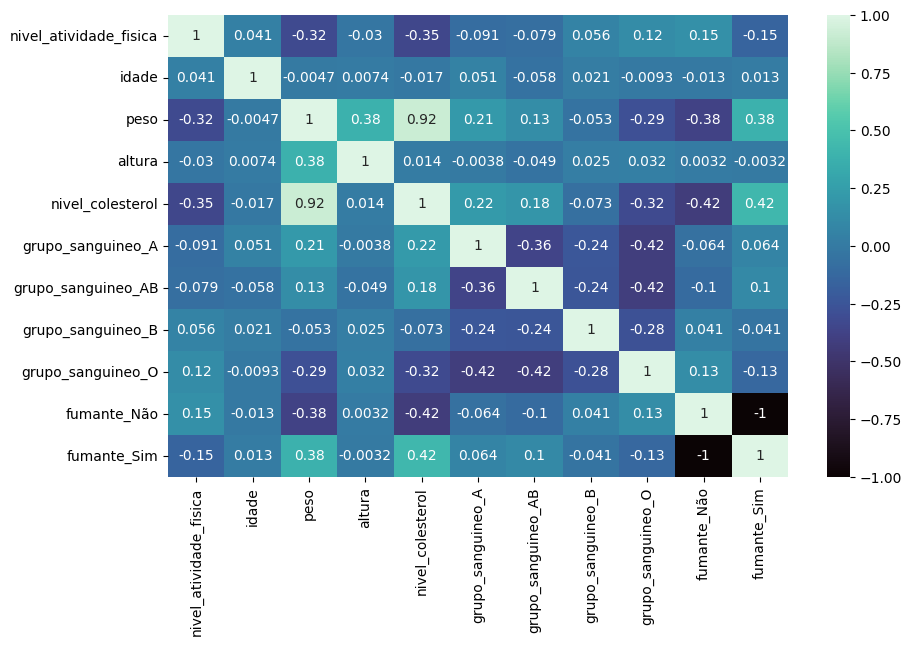

In [285]:
# Mapa de calor com correlação
plt.figure(figsize=(10,6))
sns.heatmap(df_colesterol_eda.corr(), vmin=-1, vmax=1, annot=True, cmap='mako')

<Axes: >

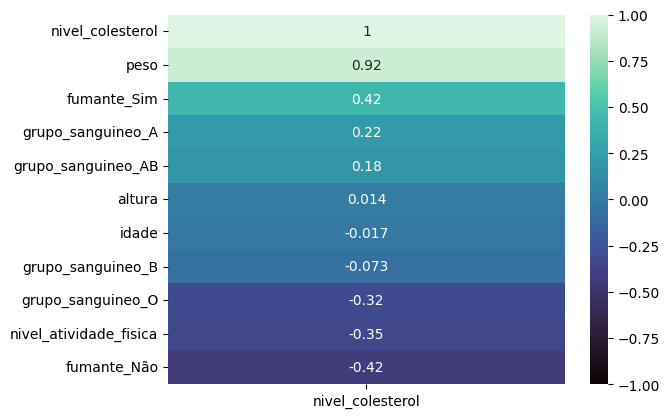

In [286]:
# Formato de ranking, somente correlação com a variável target
sns.heatmap(df_colesterol_eda.corr()[['nivel_colesterol']].sort_values(by='nivel_colesterol', ascending=False), vmin=-1,vmax=1, annot=True, cmap='mako')


Identificou-se uma correlação forte entre o peso e o nível de colesterol, assim como entre o hábito de fumar e o tipo sanguíneo. Além disso, observou-se uma correlação negativa entre o nível de colesterol e o nível de atividade física. Essas associações ressaltam a influência dessas variáveis na dinâmica do nível de colesterol, contribuindo para uma compreensão mais abrangente dos padrões identificados no estudo.

#### Análise Gráfica com Bucketing

In [287]:
# Bucketing idade
bins_idade = [20,30,40,50,60,70,80]
labels_idade = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
df_colesterol_bucketing['escala-idade'] = pd.cut(x= df_colesterol_bucketing['idade'], bins= bins_idade, labels=labels_idade, include_lowest=True)

In [288]:
df_colesterol_bucketing.head(10)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,escala-idade,escala-peso
0,B,Sim,Baixo,33.0,85.1,186.0,199.63,30-39,80-89
1,A,Não,Moderado,68.0,105.0,184.0,236.98,60-69,100-109
2,O,Não,Alto,25.0,64.8,180.0,161.79,20-29,60-69
3,A,Não,Alto,43.0,120.2,167.0,336.24,40-49,120-129
4,AB,Não,Baixo,79.0,88.5,175.0,226.23,70-79,80-89
5,B,Não,Baixo,68.0,66.8,170.0,185.31,60-69,60-69
6,A,Sim,Baixo,60.0,117.3,181.0,289.33,50-59,110-119
7,O,Sim,Moderado,35.0,86.9,174.0,216.48,30-39,80-89
8,O,Não,Baixo,62.0,81.3,166.0,235.30,60-69,80-89
9,B,Sim,Alto,44.0,32.7,165.0,97.79,40-49,NaN


<Axes: xlabel='escala-idade', ylabel='nivel_colesterol'>

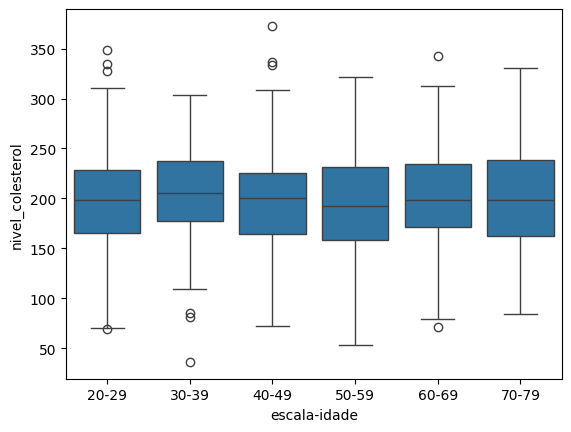

In [254]:
sns.boxplot(df_colesterol_bucketing, x='escala-idade', y='nivel_colesterol')

In [255]:
# Bucketing idade
bins_peso = [40,50,60,70,80,90,100, 110, 120, 130, 140, 150, 160]
labels_peso = ['40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100-109', '110-119', '120-129', '130-139', '140-149', '150-159']
df_colesterol_bucketing['escala-peso'] = pd.cut(x= df_colesterol_bucketing['peso'], bins= bins_peso, labels=labels_peso, include_lowest=True)

In [256]:
df_colesterol_bucketing.head(10)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,escala-idade,escala-peso
0,B,Sim,Baixo,33.0,85.1,186.0,199.63,30-39,80-89
1,A,Não,Moderado,68.0,105.0,184.0,236.98,60-69,100-109
2,O,Não,Alto,25.0,64.8,180.0,161.79,20-29,60-69
3,A,Não,Alto,43.0,120.2,167.0,336.24,40-49,120-129
4,AB,Não,Baixo,79.0,88.5,175.0,226.23,70-79,80-89
5,B,Não,Baixo,68.0,66.8,170.0,185.31,60-69,60-69
6,A,Sim,Baixo,60.0,117.3,181.0,289.33,50-59,110-119
7,O,Sim,Moderado,35.0,86.9,174.0,216.48,30-39,80-89
8,O,Não,Baixo,62.0,81.3,166.0,235.30,60-69,80-89
9,B,Sim,Alto,44.0,32.7,165.0,97.79,40-49,NaN


<Axes: xlabel='escala-peso', ylabel='nivel_colesterol'>

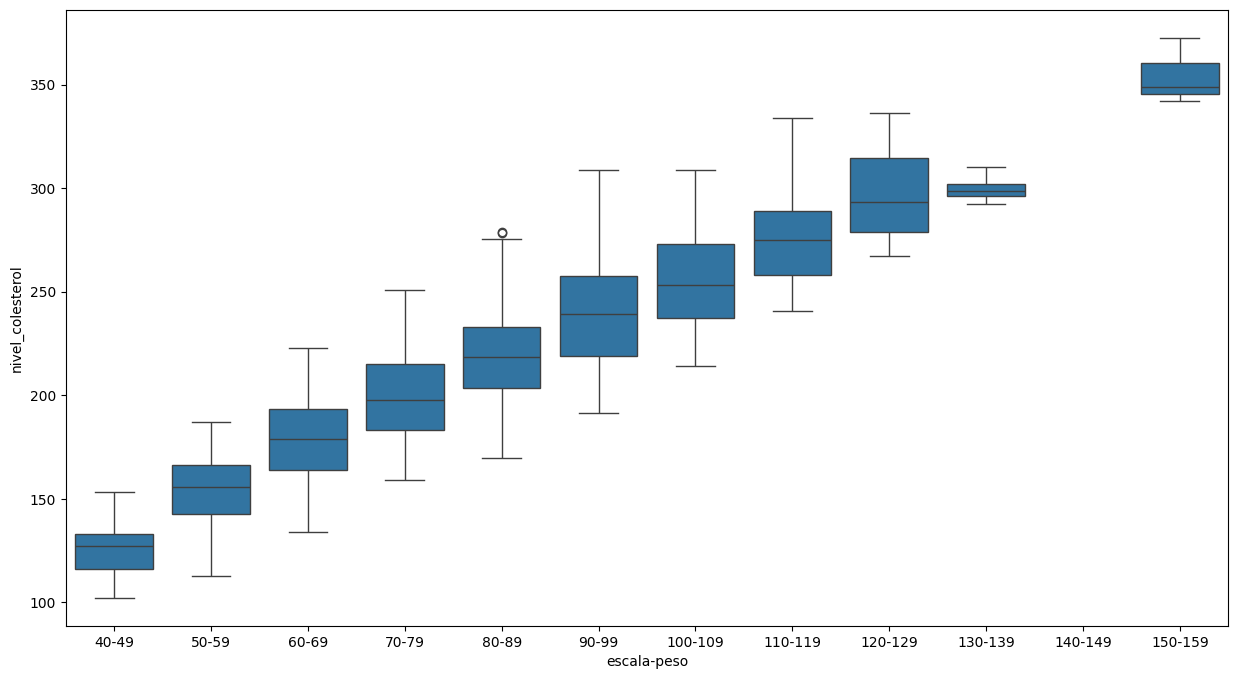

In [257]:
plt.figure(figsize=(15,8))
sns.boxplot(df_colesterol_bucketing, x='escala-peso', y='nivel_colesterol')


No que diz respeito à idade, não foi identificado um padrão claro em relação ao nível de colesterol, ao contrário do que ocorreu com o peso. 

## Preparação para Treinamento

### Split do Dataset Treino e Teste

In [135]:
# Criar Dataset de Treino e Teste
df_colesterol.drop(df_colesterol[df_colesterol['peso'] < 40].index, axis=0, inplace=True)

In [136]:
df_colesterol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 963 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grupo_sanguineo         960 non-null    object 
 1   fumante                 960 non-null    object 
 2   nivel_atividade_fisica  959 non-null    object 
 3   idade                   960 non-null    float64
 4   peso                    960 non-null    float64
 5   altura                  960 non-null    float64
 6   nivel_colesterol        963 non-null    float64
dtypes: float64(4), object(3)
memory usage: 60.2+ KB


In [137]:
X = df_colesterol.drop(columns=['nivel_colesterol'], axis=1)
y = df_colesterol['nivel_colesterol']

In [138]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=51)

utilizar o conceito de pipeline do sklearn, que auxilia no processo de automatização do processo de transformação das variáveis independentes antes de entrar no modelo. 

#### Pipeline

In [140]:
# Inputar moda nas variáveis categóricas (grupo sanguíneo, fumante, nivel atividade física)
# Padronizar variáveis numéricas (idade, peso, altura)
# One Hot Encoder nas variáveis categóricas nominais (grupo sanguíneo, fumante)
# Ordinal Encoder nas variáveis categóricas ordinais (nivel atividade física)

colunas_categoricas = ['grupo_sanguineo', 'fumante']
colunas_numericas = ['idade', 'peso', 'altura']
coluna_ordinal = ['nivel_atividade_fisica']

In [141]:
# Transformer categorico
transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),  
])

In [143]:
# Transformer ordinais
transformer_ordinal = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Baixo', 'Moderado', 'Alto']], handle_unknown='error')),  
])

In [145]:
# Transformer numerico
transformer_numeric = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),  
])

In [146]:
# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', transformer, colunas_categoricas),
        ('ord', transformer_ordinal, coluna_ordinal),
        ('num', transformer_numeric, colunas_numericas)
    ]
)

## Treinamento do Modelo com Pipelines

In [152]:
model_regr = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])

In [153]:
model_regr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['grupo_sanguineo',
                                                   'fumante']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Baixo',
                                                                                               'Moderado',
                                                                                               'Alto']]))]),
                                                  ['nivel_atividade_fisica']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['idade', 'peso',
                                                   'altura'])])),
                ('regressor', LinearRegression())])

## Validação do Modelo

### Análise de Métricas

In [154]:
# Gerar predição
y_pred = model_regr.predict(X_test)

In [155]:
# Calcular R2Score
r2_score(y_test, y_pred)

0.9593953447824033

In [156]:
# MAE
mean_absolute_error(y_test, y_pred)

7.333451557093425

In [158]:
# MSRE
mean_squared_error(y_test, y_pred, squared=False)

9.100981378172783

Com base no R2 score, podemos inferir que o modelo apresentou um desempenho satisfatório. A análise da métrica MAE sugere uma boa capacidade do modelo em prever padrões. Quanto ao MSRE, que leva em consideração outliers e valores extremos, observa-se um valor que não inviabiliza o modelo, porém, é prudente discutir esses resultados com especialistas para uma interpretação mais aprofundada.

### Análise Gráfica de Resíduos
Verificar a linearidade e a homoscedasticidade dos resíduos

In [161]:
# Cálculo residual
residuos = y_test - y_pred
# Padronização residual
residuos_std = zscore(residuos)

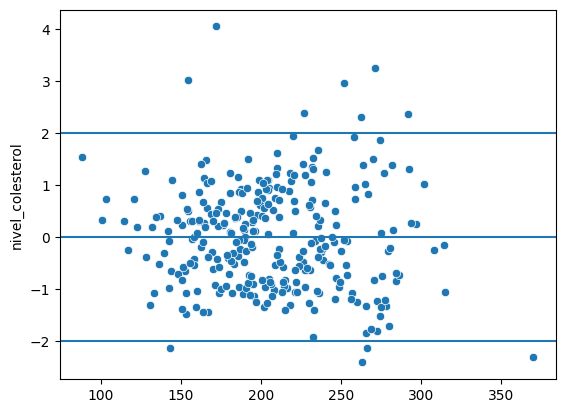

In [164]:
# Linearidade (-2 e +2)
# Homoscedasticidade (valores em torno da reta)
sns.scatterplot(x=y_pred, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=2)
plt.axhline(y=-2)


### Teste de normalidade

In [175]:
# Schapiro-Wilk 
stat_shapiro, p_value_shapiro = shapiro(residuos)
print("A estatística do teste é: {} e P-value: {}".format(stat_shapiro, p_value_shapiro))

A estatística do teste é: 0.9819086194038391 e P-value: 0.0010218769311904907


In [177]:
# Kolmogorov-Smirnov
stat_ks, p_value_ks = kstest(residuos, 'norm')
print("A estatística do teste é: {} e P-value: {}".format(stat_ks, p_value_ks))

A estatística do teste é: 0.43768164326004216 e P-value: 6.785841993979743e-51


In [179]:
# Lilliefors
stat_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print("A estatística do teste é: {} e P-value: {}".format(stat_ll, p_value_ll))

A estatística do teste é: 0.040547879216943306 e P-value: 0.37785914696759687


In [188]:
# Anderson-Darling
stat_and, critical_and, sign = anderson(residuos, dist='norm')
print("A estatística do teste é: {} e critical_and: {} ".format(stat_and, critical_and[2]))

A estatística do teste é: 0.8328247441281746 e critical_and: 0.776 


Conclui-se que três dos quatro testes indicam a falta de normalidade nos resíduos.

In [187]:
# Goldfeld-Quandt
pipe = Pipeline(steps=[('preprocessor', preprocessor)])
X_test_transformed = pipe.fit_transform(X_test)

test_gf = het_goldfeldquandt(residuos, X_test_transformed)
stat_gq = test_gf[0]
p_value_gq = test_gf[1]
print("A estatística do teste é: {} e P-value: {} ".format(stat_gq, p_value_gq))

A estatística do teste é: 0.6721735138398129 e P-value: 0.9892607822298263 


 Os resultados mostraram que não podemos rejeitar a hipótese nula, indicando que os resíduos têm variância homogênea em relação às variáveis independentes.